In [1]:
from datetime import datetime
import time

import gdax
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
NUM_LEVELS = 256
SZ = int(2e5)
INITIAL_WAIT = 10
TIME_STEP = 0.5
C_CHECKPOINTS = 100

In [13]:
class OrderBookInmensus(gdax.OrderBook):
    def __init__(self, product_id='BTC-USD', log_to=None):
        super(OrderBookInmensus, self).__init__(product_id=product_id)
        
    def on_open(self):
        self._sequence = -1
        print("-- Subscribed to OrderBook(Inmensus)! --\n")
        
    def on_error(self, e, data=None):
        self.error = e
        self.stop = True
        print('Error: {} - data: {}'.format(e, data))
        

In [14]:
order_book = OrderBookInmensus(product_id='BTC-USD')

In [15]:
order_book.start()
time.sleep(INITIAL_WAIT)
order_book.close()

-- Subscribed to OrderBook(Inmensus)! --


-- OrderBook Socket Closed! --


In [16]:
order_book.get_current_book()['bids'][-1]

[Decimal('6129.99000000'),
 Decimal('0.02000000'),
 'cf618755-3c44-4479-87a7-ffc31d86674f']

Wall time: 153 ms


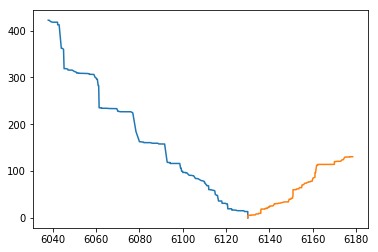

In [17]:
%%time
def aggregate(orders, is_bid):
    dfreq = {}
    for dp, dv, _ in orders:
        sp = str(dp)
        v = np.float(dv)
        if sp in dfreq:
            dfreq[sp] += v
        else:
            dfreq[sp] = v
    
    lfreq = list(dfreq.items())
    lfreq = [(np.float(p), v) for p, v in lfreq]
    lfreq.sort()
    
    if is_bid:
        return np.asarray(lfreq[-NUM_LEVELS:])
    else:
        return np.asarray(lfreq[:NUM_LEVELS])

def get_vols(order_book):
    cur_book = order_book.get_current_book()
    bid_vols = aggregate(cur_book['bids'], True)
    ask_vols = aggregate(cur_book['asks'], False)
    return bid_vols, ask_vols

bv, av = get_vols(order_book)
plt.plot(bv[:, 0], bv[:, 1].sum() - bv[:, 1].cumsum())
plt.plot(av[:, 0], av[:, 1].cumsum())

In [18]:
bid_record = np.zeros((SZ, NUM_LEVELS, 2))
ask_record = np.zeros((SZ, NUM_LEVELS, 2))
time_record = np.zeros(SZ)
print("Will last", SZ / 60.0 / 60 / 2, "hours")

Will last 27.77777777777778 hours


In [19]:
def record_order_book(idx, order_book, t):
    bv, av = get_vols(order_book)
    bid_record[idx] = bv
    ask_record[idx] = av
    time_record[idx] = t

In [20]:
%%time
record_order_book(0, order_book, time.time())

Wall time: 231 ms


In [21]:
order_book.start()
print("Doing initial sleep...")
time.sleep(INITIAL_WAIT)
print("Collecting data...")

print("Recording order_book every {} seconds for {} seconds".format(TIME_STEP, SZ / 2))
per_checkpoint = SZ // C_CHECKPOINTS
try:
    idx = 0
    for idx in range(SZ):
        beg_time = time.time()
        
        #in case of error, make sure the order_book is still open
        if order_book.stop:
            print("Orderbook is stopped, restarting...")
            order_book.start()
            print("Doing initial sleep...")
            time.sleep(INITIAL_WAIT)
            print("Collecting data...")
        
        record_order_book(idx, order_book, time.time())
        
        #logging
        print("\r", bid_record[idx,-5:,0], ask_record[idx,-5:,0], time.time() - beg_time, end="")
        if idx % per_checkpoint == 0:
            print()
        
        end_time = time.time()
        elapsed_time = end_time - beg_time
        time.sleep(max(TIME_STEP - elapsed_time, 0))
        
except KeyboardInterrupt as e:
    order_book.close()
    raise(e)

-- Subscribed to OrderBook(Inmensus)! --

Doing initial sleep...
Recording order_book every 0.25 seconds for 100000.0 seconds
 [6127.66 6128.16 6128.46 6128.56 6128.56] [6176.32 6176.76 6176.99 6177.   6178.  ] 0.10483336448669434
 [6130.72 6133.35 6134.42 6134.82 6137.86] [6229.   6229.34 6229.74 6230.   6230.03] 0.10909962654113776
 [6135.   6135.08 6135.11 6135.12 6135.69] [6223.79 6225.   6225.73 6225.99 6226.  ] 0.09307622909545898
 [6129.29 6129.49 6129.66 6129.99 6130.  ] [6212.   6212.5  6212.5  6213.11 6213.99] 0.09329462051391602
 [6126.47 6128.6  6129.   6129.6  6130.  ] [6198.64 6198.9  6199.   6199.6  6199.98] 0.10603165626525879
 [6132.85 6135.8  6135.84 6135.85 6137.66] [6217.   6217.37 6217.57 6217.91 6218.16] 0.09456562995910645
 [6132.73 6132.74 6132.75 6135.   6136.49] [6200.03 6201.4  6201.65 6201.99 6205.14] 0.09394621849060059
 [6148.83 6149.5  6149.95 6149.97 6150.  ] [6222.   6222.24 6223.   6223.02 6223.79] 0.10189628601074219
 [6145.   6145.45 6145.47 6146.04 

 [5921.89 5921.95 5921.96 5922.16 5924.89] [6007.8  6007.82 6008.84 6009.73 6010.  ] 0.11551594734191895
 [5860.86 5861.27 5861.9  5863.43 5864.2 ] [5973.   5974.   5974.28 5974.99 5975.  ] 0.12718415260314941
 [5849.98 5850.   5850.5  5850.68 5851.42] [5974.28 5974.99 5975.   5977.   5977.85] 0.11247181892395023
 [5839.97 5840.   5840.02 5841.98 5843.98] [5942.1  5942.2  5942.39 5942.75 5942.76] 0.11307621002197266
 [5813.49 5816.07 5816.12 5817.77 5819.32] [5919.95 5920.   5920.02 5920.05 5920.14] 0.09591126441955566
 [5883.99 5886.   5886.15 5889.01 5890.  ] [5917.05 5917.07 5917.14 5917.16 5917.17] 0.11165904998779297
 [5922.19 5922.2  5922.73 5922.74 5924.56] [6049.78 6050.   6050.28 6050.65 6051.  ] 0.13300299644470215
 [6201.66 6201.7  6201.71 6204.49 6208.08] [6315.19 6316.08 6316.96 6317.22 6318.  ] 0.11347389221191406
 [6165.64 6165.65 6167.56 6169.7  6169.71] [6284.99 6285.   6285.   6285.79 6287.  ] 0.09954333305358887
 [6212.98 6213.23 6215.   6217.   6217.07] [6328.32 632

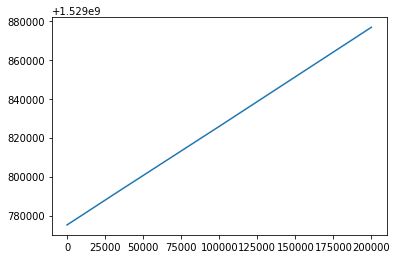

In [22]:
plt.plot(time_record)

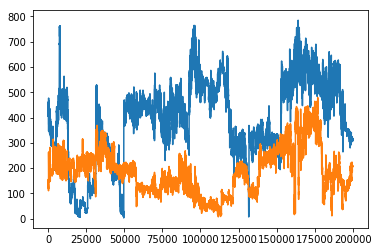

In [23]:
plt.plot(bid_record[:,:,1].sum(axis=1))
plt.plot(ask_record[:,:,1].sum(axis=1))

In [24]:
np.save('data/bid-record.npy', bid_record)
np.save('data/ask-record.npy', ask_record)
np.save('data/time-record.npy', time_record)